# Reviewer Additional Experiments

This notebook augments the aptamer–small-molecule screening study with the analyses requested by reviewers:

- Pair-level difficulty profiling linked to molecular and aptamer properties (Section B).
- SHAP analyses for Morgan fingerprints and aptamer sequence encodings with explicit substructure visualization (Section C).
- Interaction-aware neural baselines implemented locally (Section F).

All artifacts are stored under `results/reviewer_experiments/`, and only pre-existing project modules are reused.


In [3]:
!pip install shap


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sys
from pathlib import Path
from io import BytesIO
from itertools import product

root = Path.cwd()
while not (root / "src").exists() and root.parent != root:
    root = root.parent

sys.path.insert(0, str(root))

import json
import math
import os
import random
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import shap
import torch
from PIL import Image
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Crippen, Descriptors, Draw, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    matthews_corrcoef,
    roc_auc_score,
)
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

sys.path.append(str(Path.cwd()))

from src.encoders.aptamer_encoders import kmer_freq_with_type_bit, onehot_with_type_bit
from src.encoders.molecule_encoders import morgan_fp
from src.models.screening import load_splits

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 130

RESULTS_DIR = Path("results/reviewer_experiments")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH = Path("..\dataset\AptaBench_dataset.parquet")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)



c:\Users\m19er\AptaBench\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset & Base Encodings

Load the canonical AptaBench dataset, build reusable encodings (k-mer, one-hot, Morgan fingerprints), and prepare helper utilities shared across experiments.


In [2]:
df = pd.read_parquet(DATA_PATH).reset_index(drop=True)
print(f"Loaded {len(df):,} interaction records with columns: {df.columns.tolist()}")

y = df["label"].astype(int).to_numpy()
sequences = df["sequence"].fillna("").astype(str).tolist()
smiles = df["canonical_smiles"].fillna("").astype(str).tolist()



Loaded 2,001 interaction records with columns: ['type', 'sequence', 'canonical_smiles', 'pKd_value', 'label', 'buffer', 'origin', 'source']


In [3]:
BASE_PAIRS = {
    ("A", "U"), ("U", "A"), ("A", "T"), ("T", "A"),
    ("G", "C"), ("C", "G"), ("G", "U"), ("U", "G"),
    ("G", "T"), ("T", "G")
}


def safe_roc_auc(y_true, y_score):
    if len(np.unique(y_true)) < 2:
        return float("nan")
    return float(roc_auc_score(y_true, y_score))


def safe_pr_auc(y_true, y_score):
    if len(np.unique(y_true)) < 2:
        return float("nan")
    return float(average_precision_score(y_true, y_score))


def compute_metrics(y_true, y_score):
    y_pred = (y_score >= 0.5).astype(int)
    return {
        "roc_auc": safe_roc_auc(y_true, y_score),
        "pr_auc": safe_pr_auc(y_true, y_score),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "mcc": float(matthews_corrcoef(y_true, y_pred)),
    }


def gc_content(seq: str) -> float:
    seq = seq.upper().replace("U", "T")
    if not seq:
        return 0.0
    gc = sum(1 for ch in seq if ch in {"G", "C"})
    return gc / len(seq)


def kmer_entropy(seq: str, k: int = 3) -> float:
    seq = seq.upper().replace("U", "T")
    if len(seq) < k:
        return 0.0
    kmers = [seq[i : i + k] for i in range(len(seq) - k + 1)]
    if not kmers:
        return 0.0
    counts = {}
    for kmer in kmers:
        counts[kmer] = counts.get(kmer, 0) + 1
    probs = np.array(list(counts.values()), dtype=np.float64)
    probs /= probs.sum()
    return float(-(probs * np.log2(probs + 1e-12)).sum())


def nussinov_pairs(seq: str, min_loop: int = 3):
    seq = seq.upper().replace("T", "U")
    n = len(seq)
    if n == 0:
        return []
    dp = np.zeros((n, n), dtype=int)
    for l in range(1, n):
        for i in range(n - l):
            j = i + l
            pair_score = 0
            if j - i > min_loop and (seq[i], seq[j]) in BASE_PAIRS:
                pair_score = 1 + dp[i + 1, j - 1]
            split_score = 0
            if j - i > 1:
                split_score = max((dp[i, k] + dp[k + 1, j] for k in range(i, j)), default=0)
            dp[i, j] = max(dp[i + 1, j], dp[i, j - 1], pair_score, split_score)

    pairs = []

    def traceback(i, j):
        if i >= j:
            return
        if dp[i, j] == dp[i + 1, j]:
            traceback(i + 1, j)
            return
        if dp[i, j] == dp[i, j - 1]:
            traceback(i, j - 1)
            return
        if j - i > min_loop and (seq[i], seq[j]) in BASE_PAIRS and dp[i, j] == dp[i + 1, j - 1] + 1:
            pairs.append((i, j))
            traceback(i + 1, j - 1)
            return
        for k in range(i + 1, j):
            if dp[i, j] == dp[i, k] + dp[k + 1, j]:
                traceback(i, k)
                traceback(k + 1, j)
                return

    traceback(0, n - 1)
    return sorted(pairs)


def secondary_structure_summary(seq: str, min_loop: int = 3):
    pairs = nussinov_pairs(seq, min_loop=min_loop)
    if not pairs:
        return {"num_stems": 0, "num_loops": 0}
    stems = 0
    i = 0
    while i < len(pairs):
        start_i, start_j = pairs[i]
        length = 1
        while i + 1 < len(pairs) and pairs[i + 1][0] == start_i + length and pairs[i + 1][1] == start_j - length:
            length += 1
            i += 1
        stems += 1
        i += 1

    paired = {idx for pair in pairs for idx in pair}
    unpaired_runs = []
    current = 0
    for idx in range(len(seq)):
        if idx not in paired:
            current += 1
        elif current:
            unpaired_runs.append(current)
            current = 0
    if current:
        unpaired_runs.append(current)
    loops = sum(1 for run in unpaired_runs if run >= min_loop)
    return {"num_stems": stems, "num_loops": loops}


def collect_sequence_features(seq: str):
    length = len(seq)
    return {
        "length": length,
        "gc_content": gc_content(seq) if length else 0.0,
        "kmer_entropy": kmer_entropy(seq) if length else 0.0,
        **secondary_structure_summary(seq),
    }



In [4]:
MAX_APT_LEN = 216
KMER_K = 4
MORGAN_BITS = 1024
MORGAN_RADIUS = 2

apt_kmer = kmer_freq_with_type_bit(sequences, k=KMER_K).astype(np.float32)
apt_onehot = onehot_with_type_bit(sequences, max_len=MAX_APT_LEN).astype(np.float32)
apt_type_flag = apt_onehot[:, -1:].astype(np.float32)
apt_tokens = apt_onehot[:, :-1].reshape(len(df), MAX_APT_LEN, 4)
apt_embedding_norm = np.linalg.norm(apt_kmer, axis=1)

mol_morgan = morgan_fp(smiles, n_bits=MORGAN_BITS, radius=MORGAN_RADIUS).astype(np.float32)

print(
    f"Aptamer encodings: k-mer shape {apt_kmer.shape}, token tensor {apt_tokens.shape}; "
    f"Morgan fingerprints shape {mol_morgan.shape}"
)

APT_KMER_FEATURES = ["".join(p) for p in product("ACGT", repeat=KMER_K)] + ["is_rna_flag"]
MORGAN_FEATURES = [f"mol_bit_{i}" for i in range(MORGAN_BITS)]
JOINT_FEATURE_NAMES = APT_KMER_FEATURES + MORGAN_FEATURES

assert len(APT_KMER_FEATURES) == apt_kmer.shape[1], "Mismatch between k-mer features and matrix width"
assert len(JOINT_FEATURE_NAMES) == apt_kmer.shape[1] + mol_morgan.shape[1], "Joint feature list mismatch"
print(f"Registered {len(JOINT_FEATURE_NAMES)} total features for joint model analysis")



Aptamer encodings: k-mer shape (2001, 257), token tensor (2001, 216, 4); Morgan fingerprints shape (2001, 1024)
Registered 1281 total features for joint model analysis


In [ ]:
DEFAULT_LGB_PARAMS = {
    "n_estimators": 600,
    "learning_rate": 0.05,
    "num_leaves": 96,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_samples": 40,
    "reg_lambda": 1.0,
    "random_state": RANDOM_STATE,
    "n_jobs": -1,
}


def run_cv_lightgbm(X, y_vec, split_mode="stratified", params=None):
    params = (params or DEFAULT_LGB_PARAMS).copy()
    splits = load_splits(split_mode)
    oof = np.zeros(len(y_vec), dtype=np.float32)
    models = []
    metrics = []
    for fold, (tr_idx, va_idx) in enumerate(splits):
        clf = LGBMClassifier(**params)
        clf.fit(X[tr_idx], y_vec[tr_idx])
        proba = clf.predict_proba(X[va_idx])[:, 1]
        oof[va_idx] = proba
        fold_metrics = compute_metrics(y_vec[va_idx], proba)
        metrics.append({"fold": fold, **fold_metrics})
        models.append(clf)
    final_model = LGBMClassifier(**params)
    final_model.fit(X, y_vec)
    aggregate = {
        key: float(np.nanmean([m[key] for m in metrics]))
        for key in ["roc_auc", "pr_auc", "accuracy", "mcc"]
    }
    return oof, models, final_model, aggregate



### Pair-Level Difficulty Scores with Joint Optimization

Tune a single LightGBM model on concatenated aptamer k-mer features and Morgan fingerprints, select the best hyperparameters, and only then derive `difficulty = 1 - P(binding)` from its out-of-fold probabilities.


In [ ]:
joint_features = np.hstack([apt_kmer, mol_morgan])

hp_search_space = {
    "num_leaves": [64, 96, 128, 192, 256],
    "max_depth": [-1, 12, 16, 20, 24],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.08],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.65, 0.8, 0.9, 1.0],
    "min_child_samples": [20, 40, 60, 80, 100],
    "reg_lambda": [0.5, 1.0, 1.5, 2.0],
    "reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "n_estimators": [400, 600, 800, 1000],
}

rng = np.random.default_rng(RANDOM_STATE)


def sample_lgb_params():
    params = DEFAULT_LGB_PARAMS.copy()
    for key, choices in hp_search_space.items():
        params[key] = rng.choice(choices)
    return params


search_trials = 20
search_log = []
best_params = None
best_auc = -np.inf

for trial in range(1, search_trials + 1):
    candidate = sample_lgb_params()
    _, _, _, metrics = run_cv_lightgbm(
        joint_features,
        y,
        split_mode="stratified",
        params=candidate,
    )
    search_log.append({"trial": trial, **candidate, **metrics})
    if metrics["roc_auc"] > best_auc:
        best_auc = metrics["roc_auc"]
        best_params = candidate
    print(f"Trial {trial:02d}: AUC={metrics['roc_auc']:.4f}, PR={metrics['pr_auc']:.4f}")

search_results = pd.DataFrame(search_log).sort_values("roc_auc", ascending=False)
print("\nTop 3 hyperparameter settings by ROC-AUC:")
print(search_results.head(3)[[
    "trial",
    "roc_auc",
    "pr_auc",
    "num_leaves",
    "max_depth",
    "learning_rate",
    "subsample",
    "colsample_bytree",
    "min_child_samples",
    "reg_lambda",
    "reg_alpha",
    "n_estimators",
]])

print("\nBest params:")
print(best_params)

oof_probs, joint_cv_models, joint_final_model, joint_metrics = run_cv_lightgbm(
    joint_features,
    y,
    split_mode="stratified",
    params=best_params,
)

df["pred_prob"] = oof_probs
df["difficulty"] = 1.0 - df["pred_prob"].clip(0, 1)

print("\nOptimized joint LightGBM metrics (stratified splits):")
for key, val in joint_metrics.items():
    print(f"  {key}: {val:.4f}")

TOP_K_ERRORS = 10
df["abs_error"] = np.abs(df["pred_prob"] - df["label"])

print(f"\nTop {TOP_K_ERRORS} interaction-level errors:")
display(
    df.sort_values("abs_error", ascending=False)
    .head(TOP_K_ERRORS)
    [["sequence", "canonical_smiles", "label", "pred_prob", "difficulty", "abs_error"]]
)

mol_errors = (
    df.groupby("canonical_smiles", dropna=False)
    .agg(
        avg_error=("abs_error", "mean"),
        avg_pred_prob=("pred_prob", "mean"),
        interactions=("label", "count"),
    )
    .sort_values("avg_error", ascending=False)
    .head(TOP_K_ERRORS)
)
print(f"\nTop {TOP_K_ERRORS} molecules by mean absolute error:")
display(mol_errors)

apt_errors = (
    df.groupby("sequence", dropna=False)
    .agg(
        avg_error=("abs_error", "mean"),
        avg_pred_prob=("pred_prob", "mean"),
        interactions=("label", "count"),
    )
    .sort_values("avg_error", ascending=False)
    .head(TOP_K_ERRORS)
)
print(f"\nTop {TOP_K_ERRORS} aptamers by mean absolute error:")
display(apt_errors)



[LightGBM] [Info] Number of positive: 1487, number of negative: 115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11306
[LightGBM] [Info] Number of data points in the train set: 1602, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.928215 -> initscore=2.559584
[LightGBM] [Info] Start training from score 2.559584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [ ]:
BEST_JOINT_PARAMS = best_params.copy()

joint_feature_importance = pd.Series(
    joint_final_model.feature_importances_,
    index=JOINT_FEATURE_NAMES,
).sort_values(ascending=False)

print("Top 10 features by gain from the optimized joint model:")
print(joint_feature_importance.head(10))



[LightGBM] [Info] Number of positive: 1842, number of negative: 159
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2001, number of used features: 534
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.920540 -> initscore=2.449703
[LightGBM] [Info] Start training from score 2.449703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## B1. Molecular Difficulty vs Physicochemical Properties

Compute molecule-level average difficulty and correlate it with key RDKit descriptors plus Morgan fingerprint sparsity. All scatterplots include linear fits and Pearson `r`.


Saved molecular difficulty figure to results\reviewer_experiments\molecule_difficulty_vs_properties.png


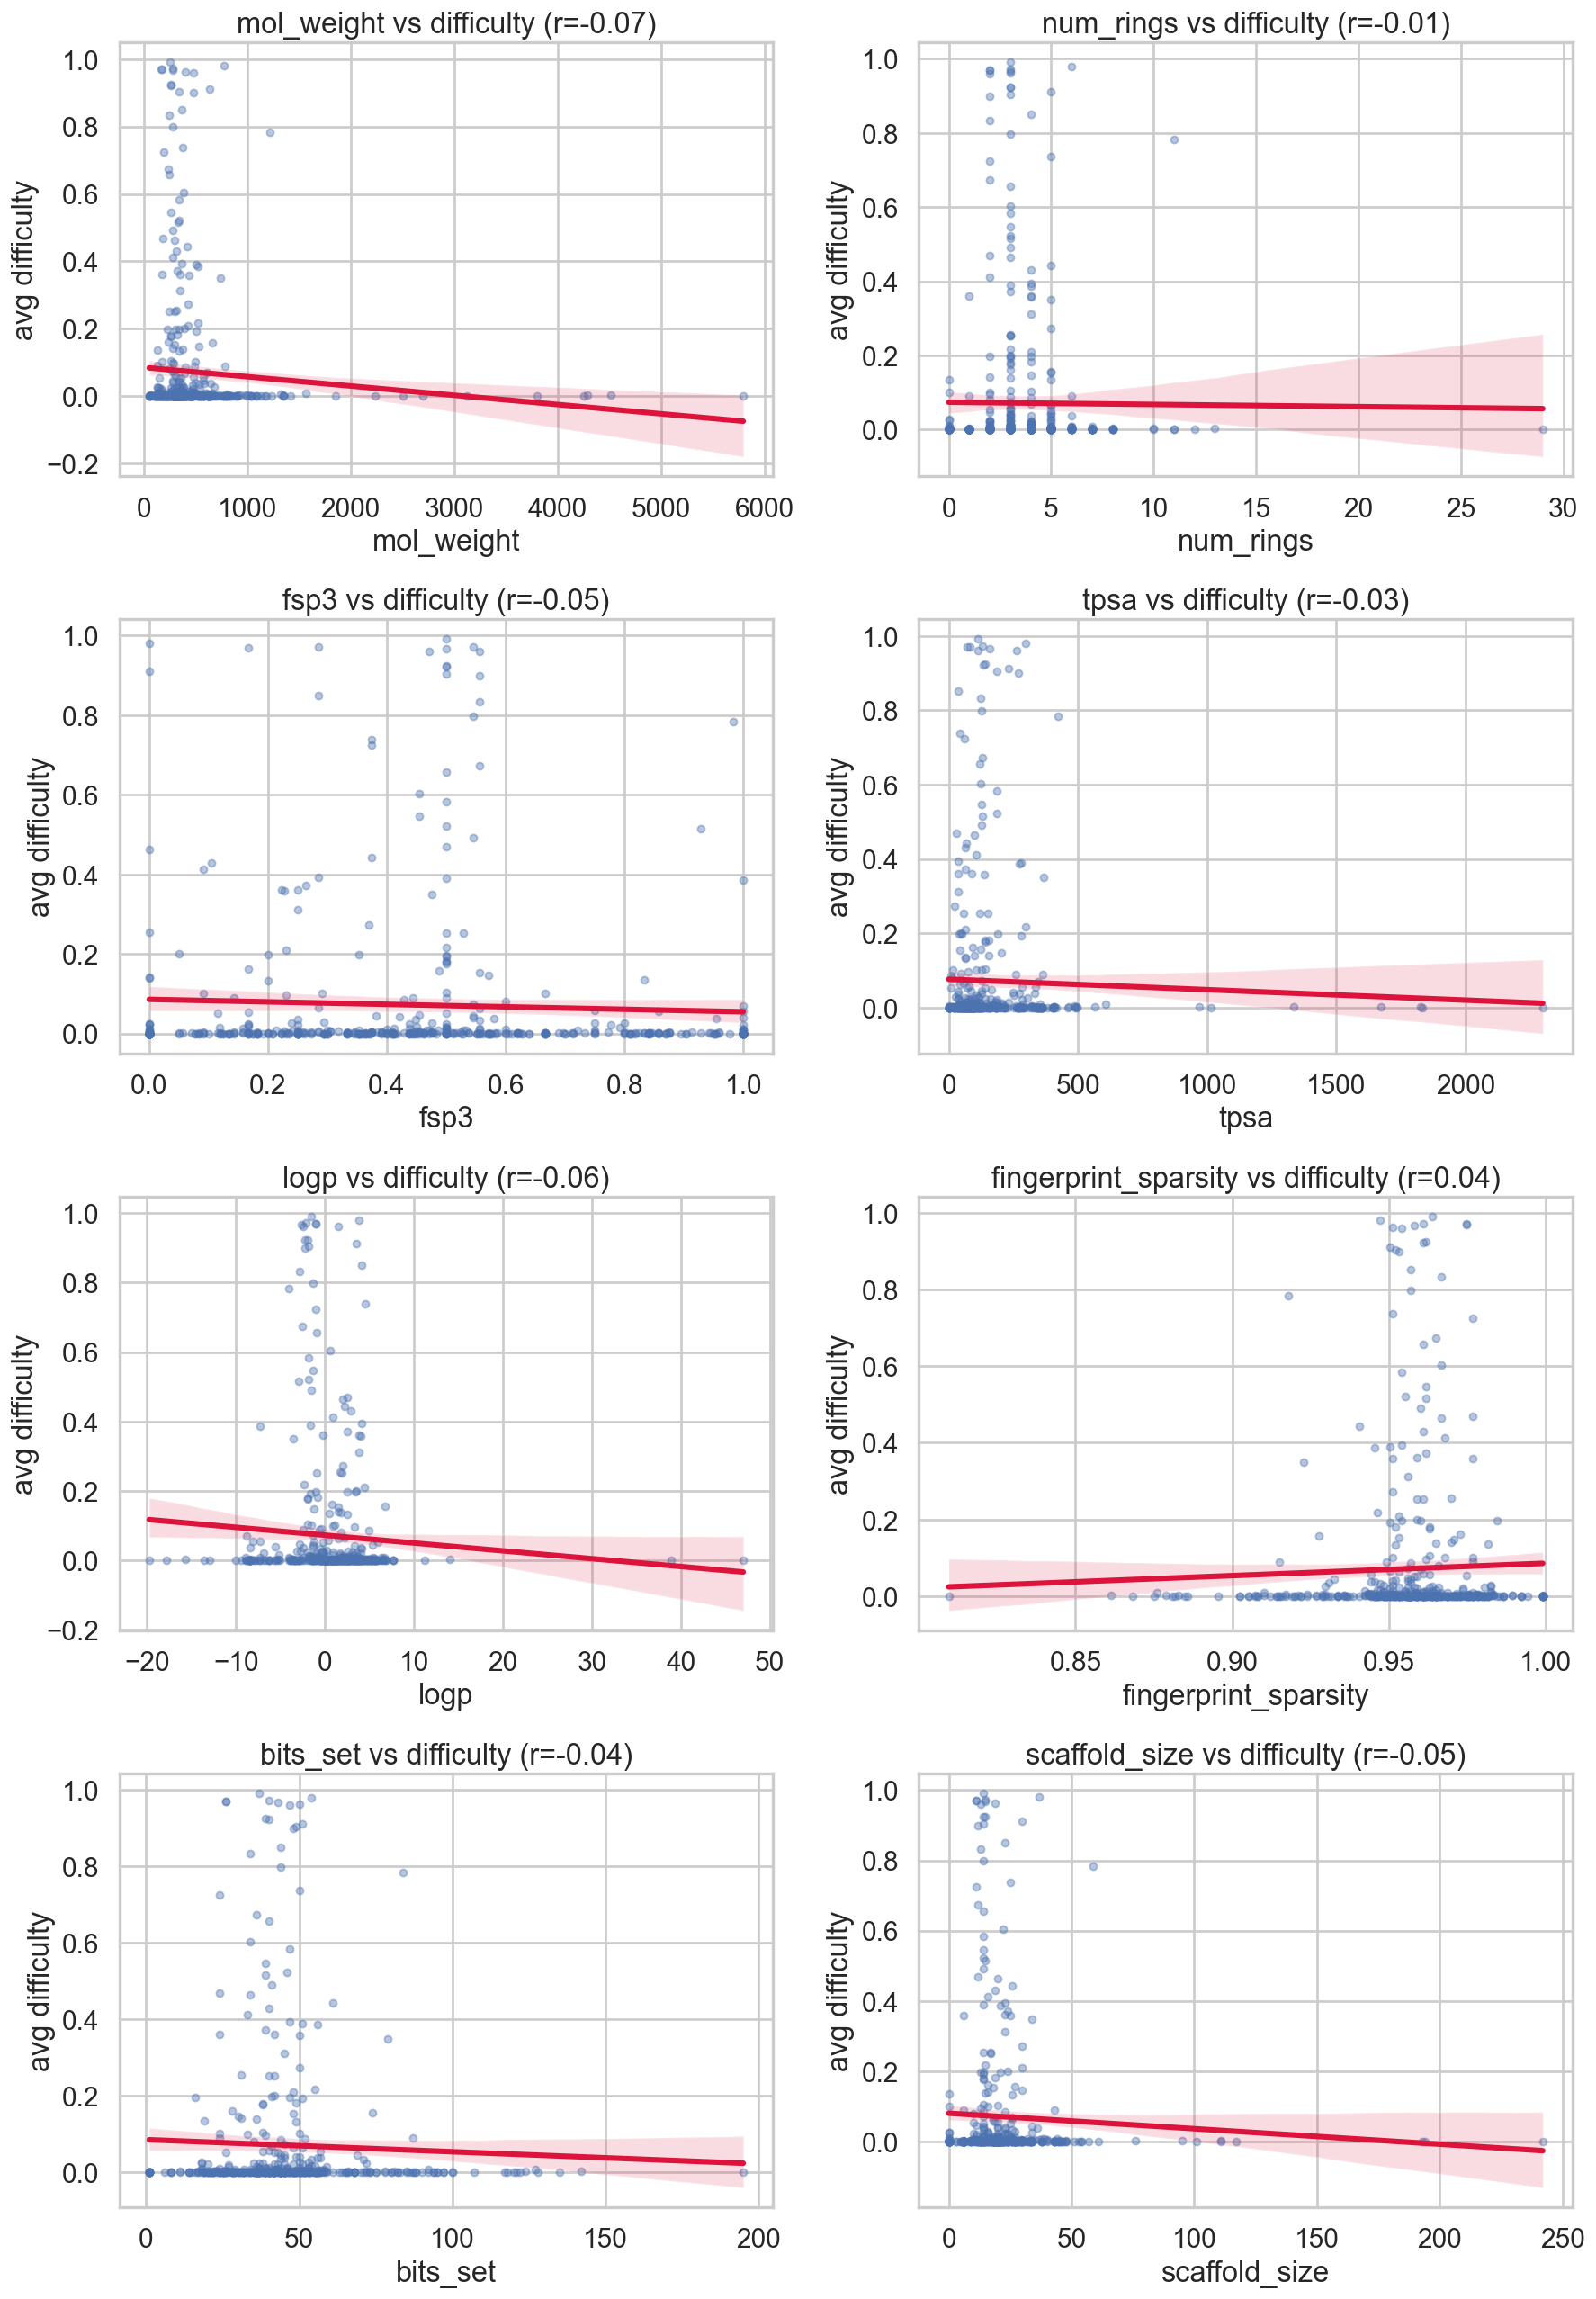

In [8]:
def molecule_property_table(smiles_list):
    unique_smiles = pd.Series(smiles_list).drop_duplicates().tolist()
    records = []
    for smi in unique_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            records.append({
                "canonical_smiles": smi,
                "mol_weight": np.nan,
                "num_rings": np.nan,
                "fsp3": np.nan,
                "tpsa": np.nan,
                "logp": np.nan,
                "scaffold_size": np.nan,
            })
            continue
        try:
            scaffold = MurckoScaffold.GetScaffoldForMol(mol)
            scaffold_size = scaffold.GetNumAtoms() if scaffold is not None else 0
        except Exception:
            scaffold_size = np.nan
        records.append({
            "canonical_smiles": smi,
            "mol_weight": Descriptors.MolWt(mol),
            "num_rings": rdMolDescriptors.CalcNumRings(mol),
            "fsp3": rdMolDescriptors.CalcFractionCSP3(mol),
            "tpsa": rdMolDescriptors.CalcTPSA(mol),
            "logp": Crippen.MolLogP(mol),
            "scaffold_size": scaffold_size,
        })
    return pd.DataFrame(records)


mol_props_df = molecule_property_table(smiles)
mol_fp_df = pd.DataFrame({
    "canonical_smiles": df["canonical_smiles"],
    "bits_set": mol_morgan.sum(axis=1),
})
mol_fp_agg = mol_fp_df.groupby("canonical_smiles", as_index=False).mean()
mol_fp_agg["fingerprint_sparsity"] = 1.0 - mol_fp_agg["bits_set"] / MORGAN_BITS

mol_difficulty = df.groupby("canonical_smiles", as_index=False)["difficulty"].mean().rename(
    columns={"difficulty": "avg_difficulty"}
)

mol_stats = mol_difficulty.merge(mol_props_df, on="canonical_smiles", how="left").merge(
    mol_fp_agg, on="canonical_smiles", how="left"
)

molecule_properties = [
    "mol_weight",
    "num_rings",
    "fsp3",
    "tpsa",
    "logp",
    "fingerprint_sparsity",
    "bits_set",
    "scaffold_size",
]

fig, axes = plt.subplots(4, 2, figsize=(14, 20))
axes = axes.flatten()
for ax, prop in zip(axes, molecule_properties):
    subset = mol_stats[["avg_difficulty", prop]].dropna()
    if subset.empty:
        ax.set_visible(False)
        continue
    r = subset["avg_difficulty"].corr(subset[prop])
    sns.regplot(data=subset, x=prop, y="avg_difficulty", ax=ax,
                scatter_kws={"s": 20, "alpha": 0.4}, line_kws={"color": "crimson"})
    ax.set_title(f"{prop} vs difficulty (r={r:.2f})")
    ax.set_ylabel("avg difficulty")
fig.tight_layout()
(fig_path := RESULTS_DIR / "molecule_difficulty_vs_properties.png")
plt.savefig(fig_path, bbox_inches="tight")
print(f"Saved molecular difficulty figure to {fig_path}")



## B2. Aptamer Difficulty vs Sequence Features

Aggregate average difficulty per unique sequence and relate it to length, GC-content, secondary-structure proxies (stems/loops), k-mer entropy, and embedding norm.


Saved aptamer difficulty figure to results\reviewer_experiments\aptamer_difficulty_vs_properties.png


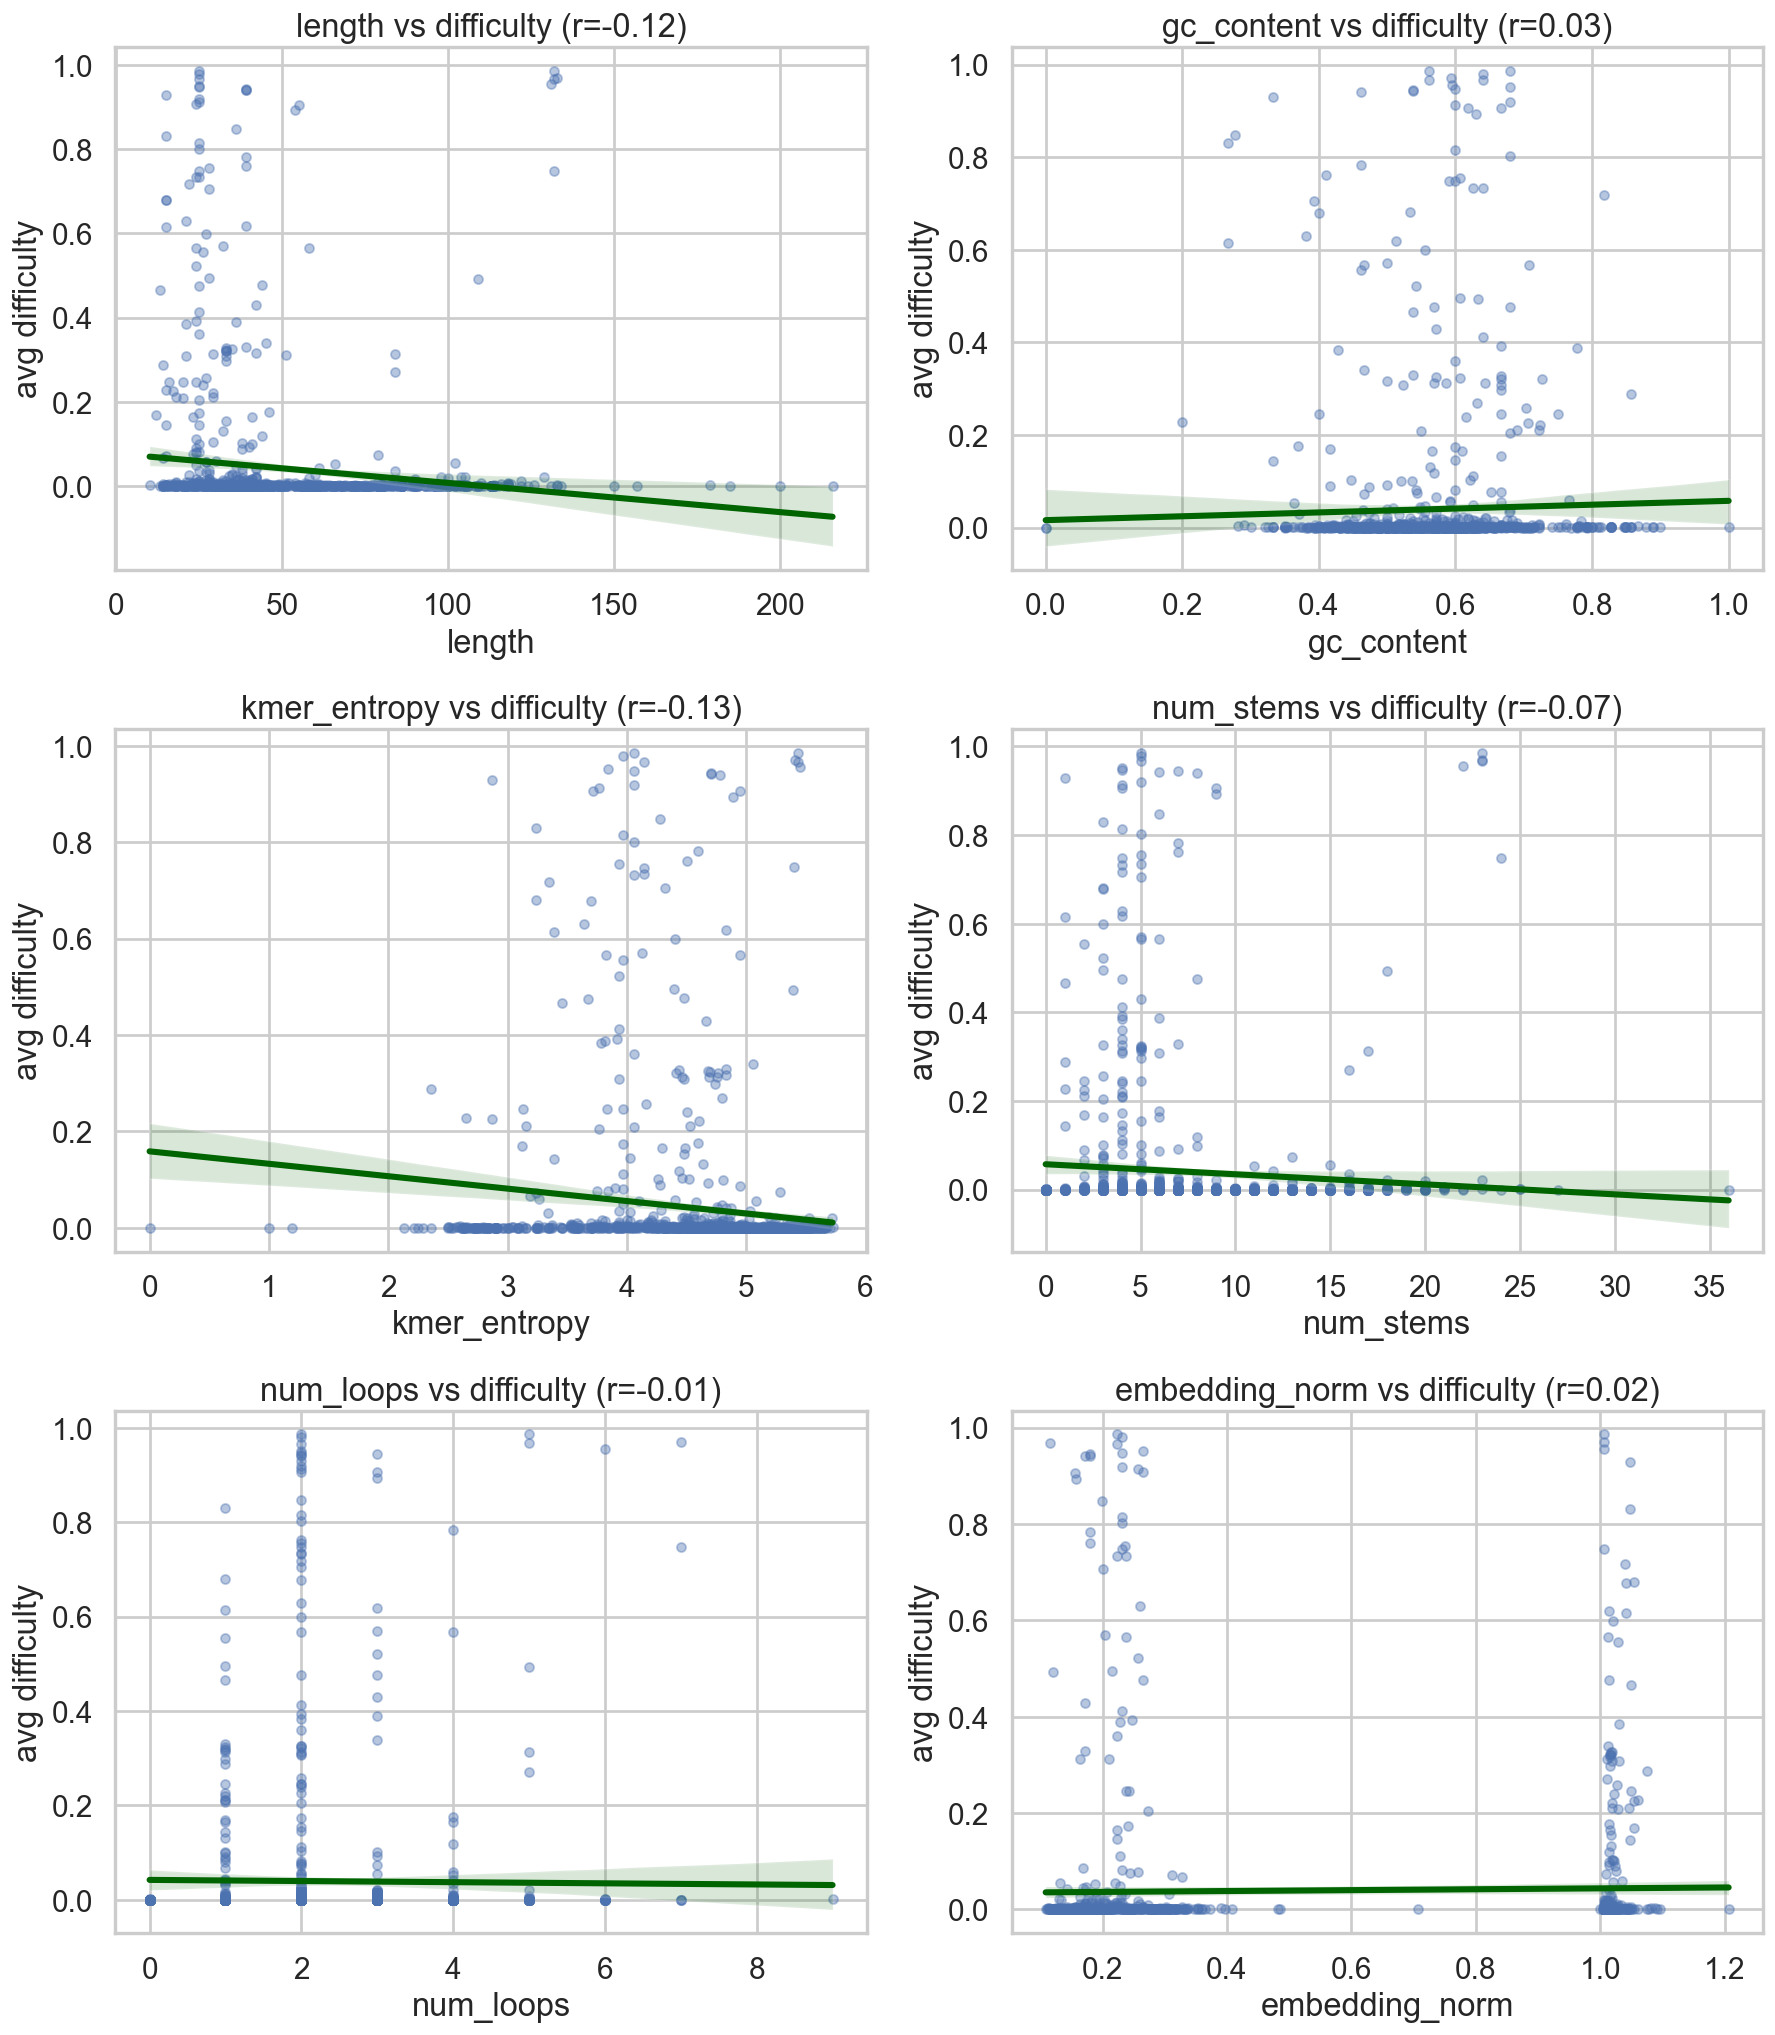

In [9]:
seq_to_first_idx = (
    df.reset_index().groupby("sequence")[["index"]].first()["index"].to_dict()
)

aptamer_records = []
for seq, group in df.groupby("sequence", dropna=False):
    seq_str = seq if isinstance(seq, str) else ""
    stats = collect_sequence_features(seq_str)
    idx = seq_to_first_idx.get(seq, group.index[0])
    stats.update({
        "sequence": seq_str,
        "avg_difficulty": group["difficulty"].mean(),
        "embedding_norm": float(apt_embedding_norm[idx]),
    })
    aptamer_records.append(stats)

aptamer_stats = pd.DataFrame(aptamer_records)

aptamer_properties = [
    "length",
    "gc_content",
    "kmer_entropy",
    "num_stems",
    "num_loops",
    "embedding_norm",
]

fig, axes = plt.subplots(3, 2, figsize=(14, 16))
axes = axes.flatten()
for ax, prop in zip(axes, aptamer_properties):
    subset = aptamer_stats[["avg_difficulty", prop]].dropna()
    if subset.empty:
        ax.set_visible(False)
        continue
    r = subset["avg_difficulty"].corr(subset[prop])
    sns.regplot(data=subset, x=prop, y="avg_difficulty", ax=ax,
                scatter_kws={"s": 25, "alpha": 0.4}, line_kws={"color": "darkgreen"})
    ax.set_title(f"{prop} vs difficulty (r={r:.2f})")
    ax.set_ylabel("avg difficulty")
fig.tight_layout()
(fig_path := RESULTS_DIR / "aptamer_difficulty_vs_properties.png")
plt.savefig(fig_path, bbox_inches="tight")
print(f"Saved aptamer difficulty figure to {fig_path}")



## C1. SHAP for Morgan Fingerprints with Substructure Visualization

Run SHAP on the optimized joint LightGBM model, isolate the Morgan-bit contributions, and reconstruct the most influential atom environments with RDKit.


In [ ]:
# Joint SHAP analysis using the optimized LightGBM model
joint_shap_sample = min(2000, len(df))
joint_shap_idx = np.random.choice(len(df), size=joint_shap_sample, replace=False)

joint_explainer = shap.TreeExplainer(joint_final_model)
joint_shap = joint_explainer.shap_values(joint_features[joint_shap_idx])
if isinstance(joint_shap, list):
    joint_shap = joint_shap[1]

mean_abs_joint = np.mean(np.abs(joint_shap), axis=0)
aptamer_cols = apt_kmer.shape[1]
morgan_cols = mol_morgan.shape[1]
aptamer_shap = joint_shap[:, :aptamer_cols]
morgan_shap = joint_shap[:, aptamer_cols:]

mean_abs_morgan = np.mean(np.abs(morgan_shap), axis=0)


def extract_submol(smi, bit_idx):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    bit_info = {}
    AllChem.GetMorganFingerprintAsBitVect(
        mol,
        radius=MORGAN_RADIUS,
        nBits=MORGAN_BITS,
        bitInfo=bit_info,
    )
    if bit_idx not in bit_info:
        return None
    atom_idx, radius = bit_info[bit_idx][0]
    env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
    amap = {}
    try:
        return Chem.PathToSubmol(mol, env, atomMap=amap)
    except Exception:
        return None


def rdkit_image_to_pil(img_obj):
    if isinstance(img_obj, (bytes, bytearray)):
        return Image.open(BytesIO(img_obj))
    if hasattr(img_obj, "data"):
        return Image.open(BytesIO(img_obj.data))
    if hasattr(img_obj, "_repr_png_"):
        return Image.open(BytesIO(img_obj._repr_png_()))
    if hasattr(img_obj, "__str__"):
        svg_text = str(img_obj)
        try:
            import cairosvg
            png_bytes = cairosvg.svg2png(bytestring=svg_text.encode("utf-8"))
            return Image.open(BytesIO(png_bytes))
        except Exception:
            pass
    raise TypeError(f"Unsupported RDKit image type: {type(img_obj)}")


TOP_N_BITS = 20
bit_order = np.argsort(mean_abs_morgan)[::-1]
submols = []
legends = []
for bit_local_idx in bit_order:
    if len(submols) >= TOP_N_BITS:
        break
    bit_idx = int(bit_local_idx)
    submol = None
    for smi in df["canonical_smiles"]:
        submol = extract_submol(smi, bit_idx)
        if submol is not None:
            break
    if submol is None:
        continue
    legends.append(
        f"{MORGAN_FEATURES[bit_idx]} |SHAP|={mean_abs_morgan[bit_idx]:.3f}"
    )
    submols.append(submol)

if submols:
    grid = Draw.MolsToGridImage(
        submols,
        molsPerRow=4,
        legends=legends,
        useSVG=False,
        returnPNG=True,
    )
    pil_img = rdkit_image_to_pil(grid)
    fig_path = RESULTS_DIR / "shap_morgan_substructures.png"
    pil_img.save(fig_path)
    print(f"Saved Morgan SHAP substructure grid to {fig_path}")
else:
    print("No valid substructures extracted for top SHAP bits.")


Saved Morgan SHAP substructure grid to results\reviewer_experiments\shap_morgan_substructures.png


## C2. SHAP for Aptamer Sequence Features

Reuse the same joint-model SHAP tensor, slice the aptamer k-mer dimensions, and inspect the dominant motifs plus their relationship with sequence-level descriptors.


In [ ]:
apt_feature_names = APT_KMER_FEATURES
mean_abs_apt = np.mean(np.abs(aptamer_shap), axis=0)
top_n = 20
top_idx = np.argsort(mean_abs_apt)[::-1][:top_n]
top_features = pd.DataFrame({
    "feature": [apt_feature_names[i] for i in top_idx],
    "importance": mean_abs_apt[top_idx],
})

sample_importance = np.abs(aptamer_shap).sum(axis=1)
sample_lengths = np.array([len(sequences[i]) for i in joint_shap_idx], dtype=float)
sample_gc = np.array([gc_content(sequences[i]) for i in joint_shap_idx], dtype=float)
sample_entropy = np.array([kmer_entropy(sequences[i]) for i in joint_shap_idx], dtype=float)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
ax_bar = axes[0, 0]
sns.barplot(data=top_features, x="importance", y="feature", ax=ax_bar, color="#4e79a7")
ax_bar.set_title("Top aptamer k-mer features by |SHAP|")
ax_bar.set_xlabel("mean |SHAP|")
ax_bar.set_ylabel("feature")

scatter_data = [
    (sample_lengths, "length"),
    (sample_gc, "gc_content"),
    (sample_entropy, "kmer_entropy"),
]
scatter_axes = [axes[0, 1], axes[1, 0], axes[1, 1]]
for (values, label), ax in zip(scatter_data, scatter_axes):
    r = np.corrcoef(values, sample_importance)[0, 1]
    sns.regplot(x=values, y=sample_importance, ax=ax,
                scatter_kws={"alpha": 0.35, "s": 30}, line_kws={"color": "purple"})
    ax.set_xlabel(label)
    ax.set_ylabel("total |SHAP| per sample")
    ax.set_title(f"Importance vs {label} (r={r:.2f})")

fig.tight_layout()
(fig_path := RESULTS_DIR / "shap_aptamer_features.png")
plt.savefig(fig_path, bbox_inches="tight")
print(f"Saved aptamer SHAP summary to {fig_path}")



## F1. Cross-Attention Fusion Baseline

Re-use the existing one-hot aptamer encoder and Morgan fingerprints, add a `torch.nn.MultiheadAttention` fusion block, and train on the standard stratified split. Results are serialized to `cross_attention_results.json`.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CrossAttentionDataset(Dataset):
    def __init__(self, indices):
        self.apt_tokens = torch.from_numpy(apt_tokens[indices]).float()
        self.apt_type = torch.from_numpy(apt_type_flag[indices]).float()
        self.mol_vec = torch.from_numpy(mol_morgan[indices]).float()
        self.labels = torch.from_numpy(y[indices]).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.apt_tokens[idx],
            self.apt_type[idx],
            self.mol_vec[idx],
            self.labels[idx],
        )


class CrossAttentionModel(nn.Module):
    def __init__(self, mol_dim, hidden_dim=256, num_heads=4, dropout=0.2):
        super().__init__()
        self.apt_proj = nn.Linear(4, hidden_dim)
        self.mol_proj = nn.Sequential(
            nn.Linear(mol_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, apt_seq, mol_vec, apt_type):
        apt_emb = self.apt_proj(apt_seq)
        mol_token = self.mol_proj(mol_vec).unsqueeze(1)
        apt_ctx, _ = self.cross_attn(apt_emb, mol_token, mol_token)
        mol_ctx, _ = self.cross_attn(mol_token, apt_emb, apt_emb)
        apt_summary = apt_ctx.mean(dim=1)
        mol_summary = mol_ctx.squeeze(1)
        fused = torch.cat([apt_summary, mol_summary, apt_type], dim=-1)
        return self.classifier(fused).squeeze(-1)


def run_cross_attention(epochs=20, batch_size=128, lr=1e-3):
    train_idx, val_idx = load_splits("stratified")[0]
    train_loader = DataLoader(
        CrossAttentionDataset(train_idx),
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
    )
    val_loader = DataLoader(
        CrossAttentionDataset(val_idx),
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
    )
    model = CrossAttentionModel(mol_dim=MORGAN_BITS).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.BCEWithLogitsLoss()
    best_state = None
    best_auc = -np.inf
    history = []

    for epoch in range(1, epochs + 1):
        model.train()
        for apt_seq, apt_type_local, mol_vec, labels in train_loader:
            apt_seq = apt_seq.to(device)
            apt_type_local = apt_type_local.to(device)
            mol_vec = mol_vec.to(device)
            labels = labels.to(device)
            logits = model(apt_seq, mol_vec, apt_type_local)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

        model.eval()
        val_probs = []
        val_labels = []
        with torch.no_grad():
            for apt_seq, apt_type_local, mol_vec, labels in val_loader:
                apt_seq = apt_seq.to(device)
                apt_type_local = apt_type_local.to(device)
                mol_vec = mol_vec.to(device)
                logits = model(apt_seq, mol_vec, apt_type_local)
                probs = torch.sigmoid(logits).cpu().numpy()
                val_probs.append(probs)
                val_labels.append(labels.numpy())
        val_probs = np.concatenate(val_probs)
        val_labels = np.concatenate(val_labels)
        metrics = compute_metrics(val_labels, val_probs)
        history.append({"epoch": epoch, **metrics})
        if metrics["roc_auc"] > best_auc:
            best_auc = metrics["roc_auc"]
            best_state = {
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "metrics": metrics,
            }
        print(f"Epoch {epoch}: AUC={metrics['roc_auc']:.4f}, PR={metrics['pr_auc']:.4f}")

    result = {
        "best_val_metrics": best_state["metrics"],
        "history": history,
        "params": {
            "epochs": epochs,
            "batch_size": batch_size,
            "lr": lr,
            "hidden_dim": 256,
            "num_heads": 4,
        },
    }
    out_path = RESULTS_DIR / "cross_attention_results.json"
    with open(out_path, "w") as f:
        json.dump(result, f, indent=2)
    print(f"Saved cross-attention metrics to {out_path}")
    return result

cross_attention_results = run_cross_attention()

